<a href="https://colab.research.google.com/github/Deepti-Shringare/Downscaling_no2map_api_RR/blob/main/DELHI_XGBOOST_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost openpyxl geemap earthengine-api folium pandas scikit-learn matplotlib numpy rasterio geopandas shapely tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00


In [ ]:
# ============================ IMPORTS ============================
import os
import ee
import geemap
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from scipy.spatial import cKDTree
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.transform import from_origin
from google.colab import files
import zipfile

# ============================ EARTH ENGINE INIT ============================
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize(project='ee-deepti')

# ============================ UPLOAD AND LOAD GROUND TRUTH (.xlsx folder as .zip) ============================
print("Upload your zipped ground truth folder (Example: cpcb_data.zip)...")
uploaded = files.upload()

zip_filename = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/cpcb_data')

ground_folder = '/content/cpcb_data/'
ground_dfs = []
for file in os.listdir(ground_folder):
    if file.endswith('.xlsx'):
        path = os.path.join(ground_folder, file)
        df = pd.read_excel(path)
        df['Station_Name'] = file.replace('.xlsx', '')
        ground_dfs.append(df)

ground_df = pd.concat(ground_dfs, ignore_index=True)

# MODIFY column names below to match your actual Excel columns:
ground_df = ground_df.rename(columns={
    'Date_Column': 'Date',        # Change this
    'NO2_Column': 'NO2',          # Change this
    'Lat_Column': 'Latitude',     # Change this
    'Lon_Column': 'Longitude'     # Change this
})

ground_df['Date'] = pd.to_datetime(ground_df['Date'])
ground_df = ground_df[ground_df['Date'].dt.year == 2023]
print(f"Ground truth loaded: {len(ground_df)} rows from {len(ground_dfs)} stations")

# ============================ UPLOAD AND LOAD SATELLITE CSV ============================
print("\nUpload your satellite CSV (Example: no2_satellite_2023.csv)...")
uploaded = files.upload()
satellite_csv_path = list(uploaded.keys())[0]
sat_df = pd.read_csv(satellite_csv_path)
sat_df['Date'] = pd.to_datetime(sat_df['Date'])
sat_df = sat_df[sat_df['Date'].dt.year == 2023]
print(f"Satellite data loaded: {len(sat_df)} rows")

# ============================ SPATIAL + TEMPORAL MERGE ============================
print("\nMatching Satellite points with nearest station measurements...")

sat_coords = sat_df[['Latitude', 'Longitude']].values
ground_coords = ground_df[['Latitude', 'Longitude']].values
tree = cKDTree(ground_coords)
distances, indices = tree.query(sat_coords, k=1)

sat_df['Station_NO2'] = ground_df.iloc[indices]['NO2'].values
sat_df['Station_Dist_km'] = distances * 111  # Roughly convert degrees to km
sat_df['Station_Date'] = ground_df.iloc[indices]['Date'].values

# Keep only where date matches (same day) and within 25 km radius
sat_df = sat_df[
    (sat_df['Date'].dt.date == pd.to_datetime(sat_df['Station_Date']).dt.date) &
    (sat_df['Station_Dist_km'] <= 25)
]
print(f"Merged records after filtering: {len(sat_df)} rows")

# ============================ GEE FEATURE EXTRACTION ============================
def extract_gee_features(lat, lon, date):
    point = ee.Geometry.Point(float(lon), float(lat))
    features = []
    try:
        lc = ee.ImageCollection('ESA/WorldCover/v200').first()
        lc_val = lc.sample(point, scale=100).first().get('Map').getInfo()
        features.append(lc_val)
    except: features.append(np.nan)

    try:
        dem = ee.Image('USGS/SRTMGL1_003')
        elev = dem.reduceRegion(ee.Reducer.mean(), point, 100).get('elevation').getInfo()
        features.append(elev)
    except: features.append(np.nan)

    try:
        night = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG') \
                .filterDate(date.strftime('%Y-%m-%d'), date.strftime('%Y-%m-%d')) \
                .mean()
        nl = night.reduceRegion(ee.Reducer.mean(), point, 500).get('avg_rad').getInfo()
        features.append(nl)
    except: features.append(np.nan)

    try:
        pop = ee.ImageCollection('JRC/GHSL/P2023A/GHS_POP').first()
        pop_val = pop.reduceRegion(ee.Reducer.mean(), point, 250).get('population').getInfo()
        features.append(pop_val)
    except: features.append(np.nan)

    return features

print("\nExtracting GEE features for each sample point...")

gee_features = []
for idx, row in tqdm(sat_df.iterrows(), total=len(sat_df)):
    try:
        feats = extract_gee_features(row['Latitude'], row['Longitude'], row['Date'])
        gee_features.append(feats)
    except:
        gee_features.append([np.nan, np.nan, np.nan, np.nan])

sat_df[['Landcover', 'Elevation', 'Nightlights', 'Population']] = pd.DataFrame(gee_features, index=sat_df.index)
sat_df = sat_df.dropna()
print(f"Samples after dropping rows with missing GEE features: {len(sat_df)}")

# ============================ XGBOOST MODEL TRAINING ============================
features = ['Station_NO2', 'Landcover', 'Elevation', 'Nightlights', 'Population']
X = sat_df[features]
y = sat_df['NO2']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"\nXGBoost Model Evaluation:\nRMSE: {rmse:.4f}\nR²: {r2:.4f}")

# ============================ FEATURE IMPORTANCE PLOT ============================
xgb.plot_importance(model, max_num_features=10)
plt.show()

# ============================ STATION-WISE VALIDATION ============================
print("\nStation-wise validation...")

results = []
for station in sat_df['Station_Name'].unique():
    station_data = sat_df[sat_df['Station_Name'] == station]
    if len(station_data) < 30: continue
    X_station = station_data[features]
    y_station = station_data['NO2']
    y_station_pred = model.predict(X_station)
    r2_stat = r2_score(y_station, y_station_pred)
    rmse_stat = np.sqrt(mean_squared_error(y_station, y_station_pred))
    results.append({'Station': station, 'R2': r2_stat, 'RMSE': rmse_stat})

station_results = pd.DataFrame(results)
print(station_results)
station_results.to_csv('/content/station_wise_validation.csv', index=False)
print("\nStation-wise validation metrics saved to /content/station_wise_validation.csv")

# ============================ GEO-TIFF EXPORT ============================
def export_as_geotiff(df, filename='downscaled_NO2.tif'):
    gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.Longitude, df.Latitude)])
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xres, yres = 0.01, 0.01  # ~1km grid
    ncols = int((xmax - xmin) / xres) + 1
    nrows = int((ymax - ymin) / yres) + 1
    transform = from_origin(xmin, ymax, xres, yres)
    raster = np.full((nrows, ncols), np.nan)

    for _, row in gdf.iterrows():
        col = int((row.geometry.x - xmin) / xres)
        row_idx = int((ymax - row.geometry.y) / yres)
        if 0 <= row_idx < nrows and 0 <= col < ncols:
            raster[row_idx, col] = row['Predicted_NO2_Fine']

    with rasterio.open(
        filename, 'w', driver='GTiff', height=nrows, width=ncols, count=1,
        dtype=raster.dtype, crs='EPSG:4326', transform=transform
    ) as dst:
        dst.write(raster, 1)

sat_df['Predicted_NO2_Fine'] = model.predict(X)
export_as_geotiff(sat_df, filename='/content/downscaled_NO2.tif')
print("\nGeoTIFF saved as: /content/downscaled_NO2.tif")

In [ ]:
!pip install xgboost openpyxl geemap earthengine-api folium pandas scikit-learn matplotlib numpy rasterio geopandas shapely tqdm


In [ ]:
# ============================ IMPORTS ============================
import os
import ee
import geemap
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from scipy.spatial import cKDTree
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
from rasterio.transform import from_origin
import rasterio
from google.colab import files
import zipfile

# ============================ EARTH ENGINE INIT ============================
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize(project='ee-deepti')

# ============================ UPLOAD AND LOAD GROUND TRUTH (.xlsx folder as .zip) ============================
print("Upload your zipped ground truth folder (Example: cpcb_data.zip)...")
uploaded_files = files.upload()

zip_filename = list(uploaded_files.keys())[0]
extract_path = '/content/cpcb_data'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

ground_dfs = []
for root, _, files in os.walk(extract_path):
    for file in files:
        if file.endswith('.xlsx'):
            path = os.path.join(root, file)
            try:
                df = pd.read_excel(path)
                # Use folder name as station name
                station_name = os.path.basename(root)
                df['Station_Name'] = station_name
                ground_dfs.append(df)
            except Exception as e:
                print(f"Error reading file {path}: {e}")


if not ground_dfs:
    raise ValueError("No .xlsx files found in the uploaded zip file or its subfolders.")

ground_df = pd.concat(ground_dfs, ignore_index=True)

# MODIFY column names below to match your actual Excel columns:
ground_df = ground_df.rename(columns={
    'Date_Column': 'Date',        # Change this
    'NO2_Column': 'NO2',          # Change this
    'Lat_Column': 'Latitude',     # Change this
    'Lon_Column': 'Longitude'     # Change this
})

ground_df['Date'] = pd.to_datetime(ground_df['Date'])
ground_df = ground_df[ground_df['Date'].dt.year == 2023]
print(f"Ground truth loaded: {len(ground_df)} rows from {len(ground_df['Station_Name'].unique())} stations")

# ============================ UPLOAD AND LOAD SATELLITE CSV ============================
print("\nUpload your satellite CSV (Example: no2_satellite_2023.csv)...")
uploaded_files = files.upload()
satellite_csv_path = list(uploaded_files.keys())[0]
sat_df = pd.read_csv(satellite_csv_path)
sat_df['Date'] = pd.to_datetime(sat_df['Date'])
sat_df = sat_df[sat_df['Date'].dt.year == 2023]
print(f"Satellite data loaded: {len(sat_df)} rows")

# ============================ SPATIAL + TEMPORAL MERGE ============================
print("\nMatching Satellite points with nearest station measurements...")

sat_coords = sat_df[['Latitude', 'Longitude']].values
ground_coords = ground_df[['Latitude', 'Longitude']].values
tree = cKDTree(ground_coords)
distances, indices = tree.query(sat_coords, k=1)

sat_df['Station_NO2'] = ground_df.iloc[indices]['NO2'].values
sat_df['Station_Dist_km'] = distances * 111  # Roughly convert degrees to km
sat_df['Station_Date'] = ground_df.iloc[indices]['Date'].values

# Keep only where date matches (same day) and within 25 km radius
sat_df = sat_df[
    (sat_df['Date'].dt.date == pd.to_datetime(sat_df['Station_Date']).dt.date) &
    (sat_df['Station_Dist_km'] <= 25)
]
print(f"Merged records after filtering: {len(sat_df)} rows")

# ============================ GEE FEATURE EXTRACTION ============================
def extract_gee_features(lat, lon, date):
    point = ee.Geometry.Point(float(lon), float(lat))
    features = []
    try:
        lc = ee.ImageCollection('ESA/WorldCover/v200').first()
        lc_val = lc.sample(point, scale=100).first().get('Map').getInfo()
        features.append(lc_val)
    except: features.append(np.nan)

    try:
        dem = ee.Image('USGS/SRTMGL1_003')
        elev = dem.reduceRegion(ee.Reducer.mean(), point, 100).get('elevation').getInfo()
        features.append(elev)
    except: features.append(np.nan)

    try:
        night = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG') \
                .filterDate(date.strftime('%Y-%m-%d'), date.strftime('%Y-%m-%d')) \
                .mean()
        nl = night.reduceRegion(ee.Reducer.mean(), point, 500).get('avg_rad').getInfo()
        features.append(nl)
    except: features.append(np.nan)

    try:
        pop = ee.ImageCollection('JRC/GHSL/P2023A/GHS_POP').first()
        pop_val = pop.reduceRegion(ee.Reducer.mean(), point, 250).get('population').getInfo()
        features.append(pop_val)
    except: features.append(np.nan)

    return features

print("\nExtracting GEE features for each sample point...")

gee_features = []
for idx, row in tqdm(sat_df.iterrows(), total=len(sat_df)):
    try:
        feats = extract_gee_features(row['Latitude'], row['Longitude'], row['Date'])
        gee_features.append(feats)
    except:
        gee_features.append([np.nan, np.nan, np.nan, np.nan])

sat_df[['Landcover', 'Elevation', 'Nightlights', 'Population']] = pd.DataFrame(gee_features, index=sat_df.index)
sat_df = sat_df.dropna()
print(f"Samples after dropping rows with missing GEE features: {len(sat_df)}")

# ============================ XGBOOST MODEL TRAINING ============================
features = ['Station_NO2', 'Landcover', 'Elevation', 'Nightlights', 'Population']
X = sat_df[features]
y = sat_df['NO2']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"\nXGBoost Model Evaluation:\nRMSE: {rmse:.4f}\nR²: {r2:.4f}")

# ============================ FEATURE IMPORTANCE PLOT ============================
xgb.plot_importance(model, max_num_features=10)
plt.show()

# ============================ STATION-WISE VALIDATION ============================
print("\nStation-wise validation...")

results = []
for station in sat_df['Station_Name'].unique():
    station_data = sat_df[sat_df['Station_Name'] == station]
    if len(station_data) < 30: continue
    X_station = station_data[features]
    y_station = station_data['NO2']
    y_station_pred = model.predict(X_station)
    r2_stat = r2_score(y_station, y_station_pred)
    rmse_stat = np.sqrt(mean_squared_error(y_station, y_station_pred))
    results.append({'Station': station, 'R2': r2_stat, 'RMSE': rmse_stat})

station_results = pd.DataFrame(results)
print(station_results)
station_results.to_csv('/content/station_wise_validation.csv', index=False)
print("\nStation-wise validation metrics saved to /content/station_wise_validation.csv")

# ============================ GEO-TIFF EXPORT ============================
def export_as_geotiff(df, filename='downscaled_NO2.tif'):
    gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.Longitude, df.Latitude)])
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xres, yres = 0.01, 0.01  # ~1km grid
    ncols = int((xmax - xmin) / xres) + 1
    nrows = int((ymax - ymin) / yres) + 1
    transform = from_origin(xmin, ymax, xres, yres)
    raster = np.full((nrows, ncols), np.nan)

    for _, row in gdf.iterrows():
        col = int((row.geometry.x - xmin) / xres)
        row_idx = int((ymax - row.geometry.y) / yres)
        if 0 <= row_idx < nrows and 0 <= col < ncols:
            raster[row_idx, col] = row['Predicted_NO2_Fine']

    with rasterio.open(
        filename, 'w', driver='GTiff', height=nrows, width=ncols, count=1,
        dtype=raster.dtype, crs='EPSG:4326', transform=transform
    ) as dst:
        dst.write(raster, 1)

sat_df['Predicted_NO2_Fine'] = model.predict(X)
export_as_geotiff(sat_df, filename='/content/downscaled_NO2.tif')
print("\nGeoTIFF saved as: /content/downscaled_NO2.tif")

Upload your zipped ground truth folder (Example: cpcb_data.zip)...


Saving DELHI-20250701T065053Z-1-001.zip to DELHI-20250701T065053Z-1-001 (3).zip
Ground truth loaded: 0 rows from 0 stations

Upload your satellite CSV (Example: no2_satellite_2023.csv)...


AttributeError: 'list' object has no attribute 'upload'

In [ ]:
import os
import pandas as pd
from google.colab import files
import zipfile

# ================= Upload the zipped ground truth folder =================
print("Upload your zipped ground truth folder (Example: cpcb_data.zip)...")
uploaded = files.upload()

# ================= Unzip the folder =================
zip_filename = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/cpcb_data')

# ================= Recursively Read All Excel Files (from all subfolders) =================
ground_dfs = []
for root, dirs, files_list in os.walk('/content/cpcb_data'):
    for file in files_list:
        if file.endswith('.xlsx'):
            file_path = os.path.join(root, file)
            try:
                df = pd.read_excel(file_path)
                # Extract station name from folder name (1 level above file)
                station_name = os.path.basename(root)
                df['Station_Name'] = station_name
                ground_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# ================= Combine All Data =================
if len(ground_dfs) == 0:
    print("❌ No .xlsx files found in your uploaded ZIP. Check folder structure.")
else:
    ground_df = pd.concat(ground_dfs, ignore_index=True)
    print(f"✅ Successfully loaded {len(ground_df)} total rows from {len(ground_dfs)} Excel files across stations.")
    print("\nColumns detected in ground truth dataset:")
    print(ground_df.columns.tolist())


Upload your zipped ground truth folder (Example: cpcb_data.zip)...


Saving AQI_hourly_2023_April_Nehru_Nagar_Delhi_DPCC_April_2023 (1).xlsx to AQI_hourly_2023_April_Nehru_Nagar_Delhi_DPCC_April_2023 (1).xlsx
✅ Successfully loaded 3861 total rows from 127 Excel files across stations.

Columns detected in ground truth dataset:
['Date', '00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00', 'Station_Name']


In [ ]:
import os
import pandas as pd
from google.colab import files
import zipfile

# ================= Upload Zipped Ground Truth Folder =================
print("👉 Upload your full CPCB folder as .zip (Example: DELHI_CPCB_2023.zip)...")
uploaded = files.upload()

# ================= Unzip to Working Directory =================
zip_filename = list(uploaded.keys())[0]
output_dir = '/content/cpcb_data'

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"✅ Folder extracted to {output_dir}")

# ================= Recursively Search all .xlsx Files (even inside subfolders and sub-subfolders) =================
ground_dfs = []

for root, dirs, files_list in os.walk(output_dir):
    for file in files_list:
        if file.endswith('.xlsx'):
            file_path = os.path.join(root, file)
            try:
                df = pd.read_excel(file_path)
                # Extract Station Name = parent folder 1 level above file
                station_folder = os.path.basename(os.path.dirname(file_path))
                df['Station_Name'] = station_folder
                ground_dfs.append(df)
            except Exception as e:
                print(f"❌ Error reading {file_path}: {e}")

# ================= Combine All into Single DataFrame =================
if len(ground_dfs) == 0:
    print("❌ No Excel files found. Please check your ZIP structure.")
else:
    ground_df = pd.concat(ground_dfs, ignore_index=True)
    print(f"✅ Loaded {len(ground_df)} total rows from {len(ground_dfs)} Excel files (all stations, all months).")
    print("\nColumns detected in ground truth dataset:")
    print(ground_df.columns.tolist())


👉 Upload your full CPCB folder as .zip (Example: DELHI_CPCB_2023.zip)...


Saving AQI_hourly_2023_April_Nehru_Nagar_Delhi_DPCC_April_2023 (1).xlsx to AQI_hourly_2023_April_Nehru_Nagar_Delhi_DPCC_April_2023 (1) (1).xlsx
✅ Folder extracted to /content/cpcb_data
✅ Loaded 3861 total rows from 127 Excel files (all stations, all months).

Columns detected in ground truth dataset:
['Date', '00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00', 'Station_Name']


In [ ]:
!pip install xgboost rasterio geopandas scikit-learn pandas openpyxl matplotlib seaborn


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving DELHI.zip to DELHI.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile('DELHI.zip', 'r') as zip_ref:
    zip_ref.extractall('DELHI')


In [ ]:
from google.colab import files
import zipfile
import os

# Upload Zip
uploaded = files.upload()

# Extract
zip_file_name = list(uploaded.keys())[0]  # Get uploaded file name dynamically

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('AirQualityData')

print("Extracted folders:", os.listdir('AirQualityData'))


Saving DELHI.zip to DELHI (1).zip
Extracted folders: ['DELHI']


In [ ]:
#GROUND TRUTH DATASET

import pandas as pd
import glob

all_files = glob.glob('AirQualityData/**/*.xlsx', recursive=True)

df_list = []

for file in all_files:
    try:
        df = pd.read_excel(file)
        # Extract station name from folder path (second level after AirQualityData/)
        station_name = file.split('/')[1]
        df['Station'] = station_name
        df_list.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Merge all stations into one DataFrame
station_df = pd.concat(df_list, ignore_index=True)
print("Merged data shape:", station_df.shape)


# --- Basic cleaning and transformation ---
# Melt the dataframe to transform hourly columns into rows
station_df_melted = station_df.melt(
    id_vars=['Date', 'Station'],
    var_name='Time',
    value_name='NO2'
)

# Drop rows with missing NO2 values
station_df_melted = station_df_melted.dropna(subset=['NO2'])

# Convert Date and Time to datetime column
station_df_melted['datetime'] = pd.to_datetime(
    station_df_melted['Date'].astype(str) + ' ' + station_df_melted['Time'].astype(str),
    errors='coerce'
)

# Drop rows where datetime conversion failed
station_df_melted = station_df_melted.dropna(subset=['datetime'])

# Display the cleaned and transformed data
print("\nCleaned and transformed data shape:", station_df_melted.shape)
print(station_df_melted.head())


#saved cleaned dataset
station_df.to_csv('Delhi_CPCB_All_Stations_Preprocessed.csv', index=False)
files.download('Delhi_CPCB_All_Stations_Preprocessed.csv')


Merged data shape: (3861, 26)

Cleaned and transformed data shape: (0, 5)
Empty DataFrame
Columns: [Date, Station, Time, NO2, datetime]
Index: []


/tmp/ipython-input-17-3229223088.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  station_df_melted['datetime'] = pd.to_datetime(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Delhi geometry loaded.
GeoTIFF Export Task started (Check GEE Tasks tab).
CSV Export Task started (Check GEE Tasks tab).
Mounted at /content/drive
   system:index  tropospheric_NO2_column_number_density  \
0             0                                0.000096   
1             1                                0.000096   
2             2                                0.000096   
3             3                                0.000096   
4             4                                0.000097   

                                                .geo  
0  {"geodesic":false,"type":"Point","coordinates"...  
1  {"geodesic":false,"type":"Point","coordinates"...  
2  {"geodesic":false,"type":"Point","coordinates"...  
3  {"geodesic":false,"type":"Point","coordinates"...  
4  {"geodesic":false,"type":"Point","coordinates"...  


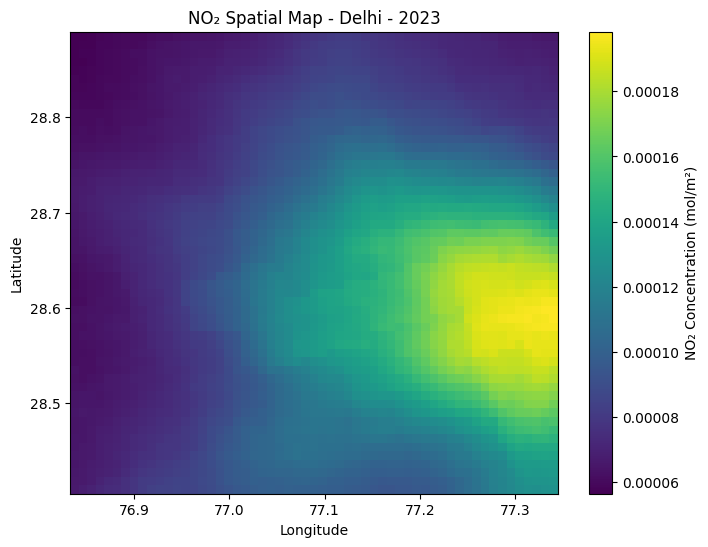

In [ ]:
#GEE DTATASET
import ee

# Authenticate and initialize with your GEE project
ee.Authenticate()
ee.Initialize(project='ee-deepti')

# Define Area of Interest - Delhi Bounding Box
delhi = ee.FeatureCollection('FAO/GAUL/2015/level2') \
            .filter(ee.Filter.eq('ADM2_NAME', 'Delhi')) \
            .geometry()

# Optional: Check the geometry
print('Delhi geometry loaded.')

# Load Sentinel-5P NO2 dataset
no2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2') \
        .filterDate('2023-01-01', '2023-12-31') \
        .filterBounds(delhi) \
        .select('tropospheric_NO2_column_number_density')

# Calculate Yearly Mean NO2
no2_mean = no2.mean()

# ──────────────────────────
# 1. Export NO2 Mean as GeoTIFF
# ──────────────────────────
geo_export = ee.batch.Export.image.toDrive(
    image=no2_mean,
    description='Delhi_NO2_2023_GeoTIFF',
    folder='GEE_Exports',
    fileNamePrefix='Delhi_NO2_2023',
    scale=1000,  # Approx 1km
    region=delhi.bounds().getInfo()['coordinates'],
    crs='EPSG:4326'
)
geo_export.start()
print("GeoTIFF Export Task started (Check GEE Tasks tab).")

# ──────────────────────────
# 2. Export Point Sample Data as CSV
# ──────────────────────────

# Create a grid of points over Delhi for sampling
grid_points = no2_mean.sample(
    region=delhi,
    scale=1000,
    projection='EPSG:4326',
    geometries=True
)

csv_export = ee.batch.Export.table.toDrive(
    collection=grid_points,
    description='Delhi_NO2_2023_CSV',
    folder='GEE_Exports',
    fileNamePrefix='Delhi_NO2_2023_Points',
    fileFormat='CSV'
)
csv_export.start()
print("CSV Export Task started (Check GEE Tasks tab).")

#READ DATASET FROM GEE IN .CSV AND .TIF FORM
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Example CSV path (change as per your file location inside Google Drive)
# Use forward slashes or double backslashes for paths
csv_path = '/content/drive/My Drive/GEE_Exports/Delhi_NO2_2023_Points.csv' # Corrected path format

# Read the CSV
satellite_df = pd.read_csv(csv_path)

# Check contents
print(satellite_df.head())

#geotiff reading
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Example GeoTIFF path (change according to your downloaded file location)
# Use forward slashes or raw strings for paths in Colab
tiff_path = '/content/drive/My Drive/GEE_Exports/Delhi_NO2_2023.tif' # Corrected path format

# Open the GeoTIFF file
with rasterio.open(tiff_path) as src:
    no2_data = src.read(1)  # Read first band
    no2_extent = src.bounds  # To get map extents (for georeferencing)

# Display the NO2 map
plt.figure(figsize=(8, 6))
plt.imshow(no2_data, cmap='viridis', extent=[no2_extent.left, no2_extent.right, no2_extent.bottom, no2_extent.top])
plt.colorbar(label='NO₂ Concentration (mol/m²)')
plt.title('NO₂ Spatial Map - Delhi - 2023') # Updated title to reflect yearly mean
plt.xlabel('Longitude') # Updated label
plt.ylabel('Latitude') # Updated label
plt.show()
